### Section 1. Import libraries ###

In [2]:
import os
import numpy as np
import rasterio as rio
import geopandas as gpd
from sys import exit
import geospatial_functions.geospatial_analysis as ga
from osgeo import gdal
from rasterio.warp import Resampling
import pandas as pd
import matplotlib.pyplot as plt 

print('Done')

Done


### Section 2. Specify file paths ###

In [4]:
# ================ INPUTS AND CONFIGURATIONS (EDITION NEEDED) ================ 
# --- PART 1. common input files ---
root_dir = '/glade/u/home/hongli/scratch/2020_06_02HRUcomplexity/discretize'
# root_dir='/Users/hongli/Documents/proj/2020_06_01HRUcomplexity/discretize'
source_data_dir = os.path.join(root_dir, 'source_data')

huc12_shp = os.path.join(source_data_dir, 'west_huc12/WEST.huc12.shp')
huc12_field   = 'HUC12' #'HUC12int'     
Tohuc12_field = 'ToHUC'

dem_raster = os.path.join(source_data_dir, 'MERIT_Hydro_dem_NLDAS.tif') # large-domain DEM raster covering the case study area. Used for clipping.
dem_nodatavalue = -9999                                                 # the value for pixels to be considered as NoData. Obtained by checking dem_raster.

lc_raster = os.path.join(source_data_dir, 'nldas_landcover.tif')        # silimar with dem_raster, but for landcover.
lc_nodatavalue = 255                                                    # silimar with dem_nodatavalue.

soil_raster = os.path.join(source_data_dir, 'usda_mode_soilclass_vCompressed_NA_250m_ll.tif') # silimar with dem_raster, but for soil.
soil_nodatavalue = np.nan                                               # silimar with dem_nodatavalue.
    
stream_shp = os.path.join(source_data_dir, 'riv_pfaf_7_MERIT_westUS_prj/riv_pfaf_7_MERIT_Hydro_v07_Basins_v01_wUS.shp')

# ---- PART 2. case study relevant inputs and configurations ----
case = 'shoshone'                                                # user-specified case study name. Used to create a case study foler to store all the case study relevant files.
outlet_hucid = '100800120304'                                    # huc12id of the outlet HUC12 of the case study area.
# case = 'tuolumne'
# outlet_hucid = '180400090504'

case_dir = os.path.join(root_dir, case)                          # case study directory. Used to store all the case study relevant files.
if not os.path.exists(case_dir): os.makedirs(case_dir)           # create case study folder if it doesn't exist.
rad_raster = os.path.join(case_dir, 'step9_merge_raw_Sw/sw.tif') # solar radiation raster for case study. Calcualted based on the reference: Allen et al., 2006. Agricultural and Forest Meteorology. 

# ---- PART 3. define GRU and HRU field names and data types ----
# note: Some avaialble dtypes for rasterio: 'int16', 'int32', 'float32', 'float64'. No 'int64'!
# reference: https://test2.biogeo.ucdavis.edu/rasterio/_modules/rasterio/dtypes.html
gruNo_field = 'gruNo'       # field name of gru number, e.g.,1,2,3...
gruNo_field_dtype = 'int32' # used to save gruNo raster. 
gruName_field = 'gruId'     # field name of gru name, e.g., 100800120101. 

hruNo_field = 'hruNo'       # field name of hru number, e.g.,1,2,3...
hruNo_field_dtype = 'int32' # used to save hruNo raster. 
hruName_field = 'hruId'     # field name of hru name, e.g., 10080012010101, 100800120102. 
hruArea_field = 'areaSqm'   # field name of hru area, used in small HRU elimination

# ---- PART 4. define common projection, nodata value, reference raster ----
proj4="+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m no_defs"
dst_crs = rio.crs.CRS.from_string(proj4)
## Albers Equal Area Conic Projection. 
## reference 1: https://gisgeography.com/conic-projection-lambert-albers-polyconic/
## reference 2: https://epsg.io/102008

nodatavalue = -9999   # used in raster generatation

# ---- PART 5. define HRU elimination threshold (two options: value, fraction) ----
# hru_thld_type = 'value'
# hru_thld = 10**6 #1km2

hru_thld_type = 'fraction'
hru_thld = 0.05  # partial of the gru area


# ================ INTERMEDIATE FILES (NO EDITION NEEDED) ================ 
dem_raster_prj = os.path.join(os.path.dirname(dem_raster), os.path.basename(dem_raster).split('.tif')[0]+'_prj.tif')
lc_raster_prj = os.path.join(os.path.dirname(lc_raster), os.path.basename(lc_raster).split('.tif')[0]+'_prj.tif')
soil_raster_prj = os.path.join(os.path.dirname(soil_raster), os.path.basename(soil_raster).split('.tif')[0]+'_prj.tif')
stream_shp_prj = os.path.join(os.path.dirname(merit_stream_shp), os.path.basename(merit_stream_shp).split('.shp')[0]+'_prj.shp')

dem_crop = os.path.join(case_dir, 'dem_crop.tif')               # DEM raster of case study. Cropped from the projected large-domain DEM raster.
refraster = dem_crop                                            # reference raster, used in vector rasterization and resample.
dem_crop_buf = os.path.join(case_dir, 'dem_crop_buf.tif')       # buffered DEM raster of case study. 
dem_class_raster_basename = os.path.join(case_dir, 'dem_class') # basename for DEM class files (e.g., 0:low elevation. 1: high elevation).
dem_value_raster_basename = os.path.join(case_dir, 'dem_value') # basename for DEM value files (e.g., average DEM per class).

slope_raster = os.path.join(case_dir, 'slope.tif')             # slope raster, calcualted based on dem_crop.
aspect_raster = os.path.join(case_dir, 'aspect.tif')           # aspect raster, calcualted based on dem_crop.

lc_crop = os.path.join(case_dir, 'landcover_crop.tif')         # landcover raster of case study. Cropped from the projected large-domain landcover raster.
lc_crop_resample = os.path.join(case_dir, 'landcover_crop_resample.tif') # resampled landcover raster according to the layout of refraster. 
lc_class_raster = os.path.join(case_dir, 'landcover_class.tif')# landcover class raster (e.g., canopy, non-canopy).

soil_crop = os.path.join(case_dir, 'soil_crop.tif')         # soil raster of case study.
stream_crop = os.path.join(case_dir, 'stream.shp')         # soil raster of case study.

gru_shp = os.path.join(case_dir, 'huc12.shp')               # GRU shapefile of case study. Cropped from the large-domain HUC12 shapefile.
huc12_list_txt = 'huc12Ids.txt'                                    # list of HUC12 ids.
gru_shp_prj = os.path.join(case_dir, 'gru_prj.shp')         # project GRU shapefile.
gru_raster = os.path.join(case_dir, 'gru.tif')              # project GRU raster file.
gru_corr_txt=os.path.join(case_dir, 'gruNo_HUC12_corr.txt') # correspondence between HUC12 and gru number (for recrod).
 
rad_class_raster_basename = os.path.join(case_dir, 'rad_class') # basename for radiation class files (e.g., 0:low. 1:high).
rad_value_raster_basename = os.path.join(case_dir, 'rad_value') # basename for radiation value files (e.g., average radiation per class).

print('Done')

Done


### Section 3. Project large rasters (once for all) ###

In [3]:
# # --- PART 1. reproject dem, landcover, and soilClass rasters --- 
# print('PART 1. reproject dem and landcover rasters')
# ga.reproject_raster(dem_raster, dem_raster_prj, dst_crs, Resampling.bilinear)    # re-project dem raster
# ga.reproject_raster(lc_raster, lc_raster_prj, dst_crs, Resampling.nearest)       # re-project land cover raster
# ga.reproject_raster(soil_raster, soil_raster_prj, dst_crs, Resampling.nearest)   # re-project soilClass raster
# ga.reproject_vector(stream_shp, stream_shp_prj, dst_crs)     

# print('Done')

PART 1. reproject dem and landcover rasters
Done


### Section 4. Clip GRU shapefile for case study ###

Round 1. Totally 3 HUCs are found.
Round 2. Totally 5 HUCs are found.
Round 3. Totally 9 HUCs are found.
Round 4. Totally 14 HUCs are found.
Round 5. Totally 18 HUCs are found.


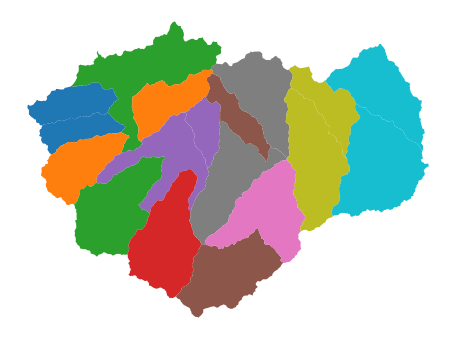

Done


In [3]:
# ---- PART 1. read large-domain HUC12 shapefile ---- 
data = gpd.read_file(huc12_shp)
# check whether two useful columns (huc12_field, Tohuc12_field) are in huc12_shp.
if not huc12_field in data.columns.values:
    exit(huc12_field+' column does not exist in shapefile.')
else:
    hucs = data[huc12_field].values
if not Tohuc12_field in data.columns.values:
    exit(Tohuc12_field+' column does not exist in shapefile.')
else:
    tohucs = data[Tohuc12_field].values
# extract only the useful columns to save data memory.
data = data[[huc12_field,Tohuc12_field,'geometry']] 

# ---- PART 2. search upstream HUCs ---- 
# method 1: search upstream hucs base on the most downstream hucId
upstream_hucs = [outlet_hucid]                              # list of upstream hucs. initiate with outlet_hucid
huc_found = np.unique(hucs[np.where(tohucs==outlet_hucid)]) # find all the upstream hucs that drain to outlet_hucid.
upstream_hucs.extend(list(huc_found))                            # add the found upstream hucs of outlet_hucid to upstream_hucs list. 
round_num = 0                                                    # record the round number of searching.

while len(huc_found) != 0: # terminate searching upstream hucs until no one can be found any more.

    round_num = round_num+1
    print("Round %d. Totally %d HUCs are found." % (round_num, len(upstream_hucs)))

    # search upstream hucs
    huc_found_next = []
    for huc_i in huc_found:
        huc_found_next.extend(list(hucs[np.where(tohucs==huc_i)]))
    huc_found_next = ga.unique(huc_found_next)

    # identify if the found HUCs exist in upstrm_hucs
    huc_found = [huc for huc in huc_found_next if not huc in upstream_hucs]
    upstream_hucs.extend(huc_found)

#     # method 2: manually add upstream_hucs when the list of upstream hucs is known. 
#     # here huc12 list is from the bighorn model forcing nc file (hurId).
#     upstream_hucs= np.loadtxt('/glade/u/home/andywood/proj/SHARP/wreg/bighorn/prep/lists/hucIds.06279940.txt',dtype=int)
#     upstream_hucs=[100800120304, 100800120302, 100800120303, 100800120301,100800120209, 100800120207, 100800120204, 100800120205, 100800120208,
#                 100800120206, 100800120105, 100800120201, 100800120202, 100800120203,100800120101, 100800120102, 100800120103, 100800120104]

# ---- PART 3. save upstream HUC12 to text and shapefile ---- 
np.savetxt(os.path.join(case_dir, huc12_list_txt), upstream_hucs, fmt='%s')
data[data[huc12_field].isin(upstream_hucs)].to_file(os.path.join(case_dir,gru_shp))
 
# ---- PART 4. plot found HUC12s ---- 
ga.plot_vector(os.path.join(case_dir,gru_shp), huc12_field)

print('Done')

### Section 5. Prepare rasters by crop, resample and classify ###

In [36]:
# --- PART 1. reproject basin vector ---
print('PART 1. reproject basin vector')
ga.reproject_vector(gru_shp, gru_shp_prj, dst_crs) # re-project gru shapefile

# --- PART 2. crop useful rasters for HRU generation and zonal statistics ---
print('PART 2. crop')
# (1) based on original basin extent, crop all the useful rasters (e.g., dem, landcover, soil).
ga.crop_raster(dem_raster_prj,gru_shp_prj,dem_nodatavalue,dem_crop)
ga.crop_raster(lc_raster_prj,gru_shp_prj,lc_nodatavalue,lc_crop) # 255 is nodatavalue for landcover raster
ga.crop_raster(soil_raster_prj,gru_shp_prj,soil_nodatavalue,soil_crop) # nan is nodatavalue for soil raster

# (2) clip streamline
stream_gpd = gpd.read_file(stream_shp_prj)
boundary_gpd = gpd.read_file(gru_shp_prj)
in_gpd_clip = gpd.clip(stream_gpd, boundary_gpd)
in_gpd_clip.to_file(stream_crop)

# --- PART 3. resample HRU-generation needed rasters to refraster ---
print('PART 3. resample rasters')
# (1) landcover
ga.resample_raster(lc_crop,refraster,lc_crop_resample) 

# --- PART 4. classify HRU-generation needed rasters that are independent of any other inputs ---
print('PART 4. classify rasters')
# relassify landcover raster 
# Note: here we make only two classes: crop vs. non-crop
# Crop class includes: 0 Evergreen needleleaf forests, 1 Evergreen broadleaf forests, 
# 2 Deciduous needleleaf forests, 3 Deciduous broadleaf forests, 4 Mixed forests, 6 Closed shrublands, 7 Woody savannas.  
ga.classify_discrete_landcover(lc_crop_resample, lc_class_raster, nodatavalue)
  
# --- PART 5. rasterize gru ---
print('PART 5. rasterize gru')
infield = huc12_field
infield_rename = gruName_field
ga.rasterize_gru_vector(gru_shp_prj,infield,gruName_field,gruNo_field,gruNo_field_dtype,
                        refraster,gru_raster,gru_corr_txt,nodatavalue)

# --- PART 6. calculate slope and aspect if needed ---
print('PART 6. calculate slope and aspect')
gdal.DEMProcessing(slope_raster, dem_crop, 'slope')
gdal.DEMProcessing(aspect_raster, dem_crop, 'aspect',zeroForFlat=True)

print('Done')

PART 1. crop rasters
PART 2. resample rasters
PART 3. classify rasters
PART 4. rasterize gru
PART 5. calculate slope and aspect
Done


### Section 6a. Check slope and aspect results ###

<Figure size 432x288 with 0 Axes>

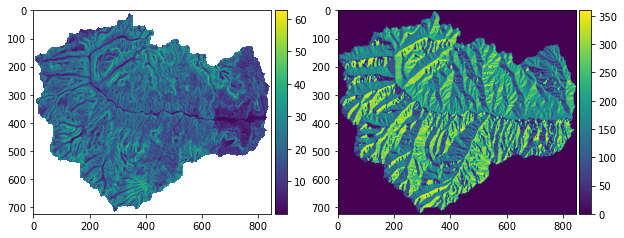

In [37]:
import rasterio as rio
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable

def read_raster(file):   
    with rio.open(file) as ff:
        data  = ff.read(1)
        mask = ff.read_masks(1)
    data_ma = np.ma.masked_array(data, mask==0)
    return data_ma

def plot_locatable_axes(data, ax):
    # reference: https://matplotlib.org/stable/gallery/axes_grid1/demo_axes_divider.html#sphx-glr-gallery-axes-grid1-demo-axes-divider-py
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig = ax.get_figure()
    fig.add_axes(ax_cb)

    im = ax.imshow(data)
    plt.colorbar(im, cax=ax_cb)
    ax_cb.yaxis.tick_right()


plt.figure()
f, ax = plt.subplots(1,2, figsize=(10,10)) 
slp_ma = read_raster(slope_raster)
plot_locatable_axes(slp_ma, ax[0])

asp_ma = read_raster(aspect_raster)
plot_locatable_axes(asp_ma, ax[1])


### Section 6b. classify aspect to check its correctness ###

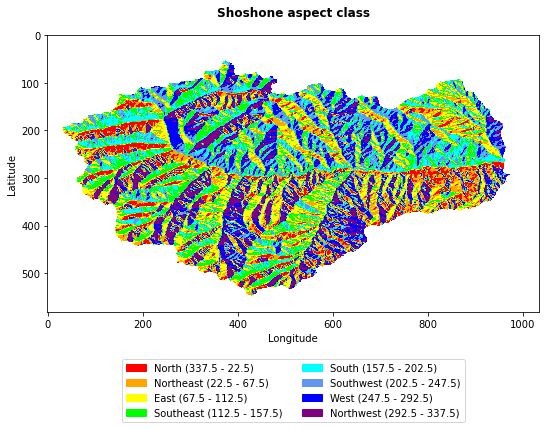

Done


In [84]:
import os
import geospatial_functions.geospatial_plot as gp

root_dir = '/glade/u/home/hongli/scratch/2020_06_02HRUcomplexity/discretize'
case = 'shoshone'                                             # user-specified case study name. Used to create a case study foler to store all the case study relevant files.
case_dir = os.path.join(root_dir, case)                       # case study directory. Used to store all the case study relevant files.
aspect_raster = os.path.join(case_dir, 'aspect.tif')           # aspect raster, calcualted based on dem_crop.
stream_shp = os.path.join(case_dir, 'stream.shp')

# # 1. classify aspect into 8 classes
# aspect_class_raster = os.path.join(case_dir, os.path.basename(aspect_raster).split('.tif')[0]+'_class.tif')        
# # # ga.classify_aspect(aspect_raster, 8, aspect_class_raster, nodatavalue)
 
# inraster, class_num, class_outraster, nodatavalue = aspect_raster, 8, aspect_class_raster, nodatavalue
# # read inraster data
# with rio.open(inraster) as ff:
#     data  = ff.read(1)
#     data_mask = ff.read_masks(1)
#     out_meta = ff.meta.copy()
# data_ma = np.ma.masked_array(data, data_mask==255)

# # define array in the same shape of data, and specify dtype!
# data_class = np.ones(np.shape(data), dtype=np.int32)*int(nodatavalue)

# # reclassify aspect
# # reference: https://www.neonscience.org/resources/learning-hub/tutorials/classify-raster-thresholds-py
# if class_num == 4:
#     data_class[np.where((data_ma==0))] = 0                    # flat
#     data_class[np.where((data_ma>0) & (data_ma<=45))] = 1     # north
#     data_class[np.where((data_ma>45) & (data_ma<=135))] = 2   # east
#     data_class[np.where((data_ma>135) & (data_ma<=225))] = 3  # south
#     data_class[np.where((data_ma>225) & (data_ma<=315))] = 4  # west
#     data_class[np.where((data_ma>315) & (data_ma<=360))] = 1  # north
# elif class_num == 8:
#     data_class[np.where((data_ma==0))] = 0                       # flat
#     data_class[np.where((data_ma>0) & (data_ma<=22.5))] = 1      # north
#     data_class[np.where((data_ma>22.5) & (data_ma<=67.5))] = 2   # northeast
#     data_class[np.where((data_ma>67.5) & (data_ma<=112.5))] = 3  # east
#     data_class[np.where((data_ma>112.5) & (data_ma<=157.5))] = 4 # southeast
#     data_class[np.where((data_ma>157.5) & (data_ma<=202.5))] = 5 # south
#     data_class[np.where((data_ma>202.5) & (data_ma<=247.5))] = 6 # southwest
#     data_class[np.where((data_ma>247.5) & (data_ma<=292.5))] = 7 # west
#     data_class[np.where((data_ma>292.5) & (data_ma<=337.5))] = 8 # northwest
#     data_class[np.where((data_ma>337.5) & (data_ma<=360))] = 1   # north

# # mask data_class and data_value
# data_class_ma = np.ma.masked_array(data_class,data_mask==255)

# # save data_class_ma into rasters
# out_meta.update(count=1, dtype='int32', compress='lzw', nodata=nodatavalue)
# with rio.open(class_outraster, 'w', **out_meta) as outf:
#     outf.write(data_class_ma, 1)    

# print('Done')

# 2. plot classified aspect
# define legend dictionary. dist[raster_value]=list(color,label)
legend_dict={0:["black", "Flat (0)"],
             1:["red", "North (337.5 - 22.5)"],
             2:["orange", 'Northeast (22.5 - 67.5)'],
             3:["yellow", 'East (67.5 - 112.5)'], 
             4:["lime", 'Southeast (112.5 - 157.5)'], 
             5:["cyan", 'South (157.5 - 202.5)'], 
             6:["cornflowerblue", 'Southwest (202.5 - 247.5)'], 
             7:["blue", 'West (247.5 - 292.5)'], 
             8:["purple", 'Northwest (292.5 - 337.5)']} 

label_dict = {0:"Flat (0)",
              1:"North (337.7 - 22.5)",
              2:'Northeast (22.5 - 67.5)',
              3:'East (67.5 - 112.5)', 
              4:'Southeast (112.5 - 157.5)', 
              5:'South (157.5 - 202.5)', 
              6:'Southwest (202.5 - 247.5)', 
              7:'West (247.5 - 292.5)', 
              8:'Northwest (292.5 - 337.5)'}

wgs_crs = 'epsg:4326'
figsize=(9,9*0.65) # width, height in inches
title = case.capitalize()+' aspect class'
leg_ncol=2
leg_loc='upper center'
leg_bbox_to_anchor=(0.5,-0.15)
ofile = os.path.join(case_dir, 'plot', 'aspect_class_raw.png')   

# inraster,bound_vector,wgs_crs,cmap_str,input_dict,figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile=\
# lc_crop,sub_shp_prj,wgs_crs,'jet',label_dict,figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile
inraster,bound_vector,wgs_crs,cmap_str,input_dict,figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile,nodatavalue=\
aspect_class_raster,gru_shp,wgs_crs,'user',legend_dict,figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile,nodatavalue

# gp.plot_discrete_raster(inraster,bound_vector,wgs_crs,cmap_str,input_dict,
#                         figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile)

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rasterio.shutil
import rasterio.plot 
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

## Part 1. pre-process raster data, color, legend
#  1. reproject raster by creating a VRT file, which is merely a ASCII txt file --- 
# that just contains reference to the referred file. This is useful to avoid duplicating raster files.
# reference: https://geohackweek.github.io/raster/04-workingwithrasters/
raster_vrt_file = os.path.join(os.path.dirname(inraster), 
                            os.path.basename(inraster).split('.')[0]+'_vrt.tif')
with rio.open(inraster) as src:
    with rio.vrt.WarpedVRT(src, crs=wgs_crs, resampling=rio.enums.Resampling.nearest) as vrt:
        rio.shutil.copy(vrt, raster_vrt_file, driver='VRT')

#  2. read the reprojected raster 
with rio.open(raster_vrt_file,nodata=nodatavalue) as src:
    data  = src.read(1)
    data_mask = src.read_masks(1)

data_ma = np.ma.masked_array(data, data_mask==0)
data_unique,data_counts= np.unique(data[data!=nodatavalue],return_counts=True) # unique values and counts

# 3. create colormap, norm and legend (two options)
# method 1. use user-specified cmap
if cmap_str!='user':
    vals = np.arange(int(data_unique.max()+1))/float(data_unique.max())
    colors =  mpl.cm.get_cmap(cmap_str)
    cols = colors(vals)
    cmap = mpl.colors.ListedColormap(cols, int(data_unique.max())+1)

    legend_labels = {}
    count_record = []
    for data_i in data_unique:
        data_i_color = cols[np.where(data_unique==data_i)][0]
        data_i_label = input_dict[data_i]
        legend_labels[data_i]=[data_i_color,data_i_label]
        count_record.append([data_i,data_i_label,int(data_counts[data_unique==data_i])])

# method 2. use user-defined colors
elif cmap_str=='user':

    legend_labels = {} # used to create legend
    count_record = []  # usde to record class count
    colors = []        # used to create cmap
    for data_i in data_unique:
        data_i_color = input_dict[data_i][0] #cols[np.where(unique==data_i)]
        data_i_label = input_dict[data_i][1]
        legend_labels[data_i]=[data_i_color,data_i_label]
        count_record.append([data_i,data_i_label,int(data_counts[data_unique==data_i])])
        colors.append(data_i_color)
    cmap = ListedColormap(colors, len(data_unique)) # Define the colors you want based on raster values    

## Part 2. plot
fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
fig.suptitle(title, weight='bold') 


# 2.1. plot raster using rasterio.plot.show in order to show coordinate
raster_image = rasterio.plot.show(data_ma,ax=ax,cmap=cmap)     #transform=src.transform,

# 2.2. plot basin boundary
bound_gpd = gpd.read_file(bound_vector)
bound_gpd_prj = bound_gpd.to_crs(wgs_crs)
bound_gpd_prj['new_column'] = 0
gpd_new = bound_gpd_prj.dissolve(by='new_column')
gpd_new.boundary.plot(color=None,edgecolor='k',linewidth=1,ax=ax) 

# 2.3. plot streamline
stream_gpd = gpd.read_file(stream_shp)
stream_gpd_prj = stream_gpd.to_crs(wgs_crs)
stream_gpd_prj.plot(color='darkblue', linewidth=1.5, ax=ax)

# 2.3. plot legend
if cmap_str!='user':
    patches = [Patch(color=legend_labels[key][0], label=legend_labels[key][1][1]) for key in legend_labels]
else:
    patches = [Patch(color=legend_labels[key][0], label=legend_labels[key][1]) for key in legend_labels]

basin_bound = mpl.patches.Patch(edgecolor='black', linewidth=1, fill=False, label='Basin')
patches.append(basin_bound)

stream_line = mpl.lines.Line2D([], [], color='darkblue', linewidth=1.5, marker=None, label='Streamline')
patches.append(stream_line)

plt.legend(handles=patches, bbox_to_anchor=leg_bbox_to_anchor, loc=leg_loc, ncol=leg_ncol, fancybox=True)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.savefig(ofile, bbox_inches='tight',dpi=150)   
plt.show()

# 2.5. save count record to txt --- 
count_ofile = os.path.join(os.path.dirname(ofile), os.path.basename(ofile).split('.')[0]+'.txt')
count_sum = np.sum(data_counts)
with open(count_ofile,'w') as f:
    f.write('#RasterValue,Label,Count,Proportion\n')
    for i in range(len(count_record)):
        f.write('%d,%s,%d,%.4f\n'%(count_record[i][0],count_record[i][1],count_record[i][2],
                                   count_record[i][2]/float(count_sum)))  

print('Done')

In [78]:
patches

In [62]:
stream_shp

'/glade/u/home/hongli/scratch/2020_06_02HRUcomplexity/discretize/shoshone/stream.shp'

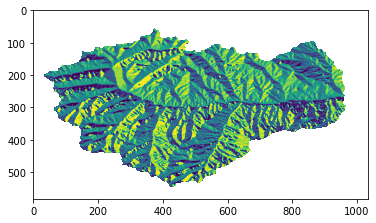

In [44]:
rasterio.plot.show(data_ma)     


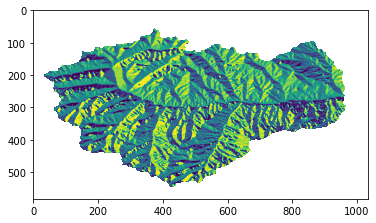

In [45]:
plt.imshow(data_ma)

In [46]:
np.unique(data_ma)

masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, --],
             mask=[False, False, False, False, False, False, False, False,
                    True],
       fill_value=999999,
            dtype=int32)

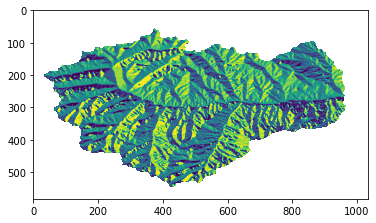

In [39]:
plt.imshow(data_ma)